In [1]:
# %% Tabular feature prep (train-only stats) + DataLoaders with audio+tabs
import os, time, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import librosa

In [2]:
# ----------------- Config (EFS paths, batch, etc.) -----------------
EFS_ROOT   = "/mnt/custom-file-systems/efs/fs-0a84517bf3cf54d59_fsap-04bd72a3f345b82c0/dialect-modeling"
MODEL_PATH = f"{EFS_ROOT}/models/model9.model"
TRAIN_PATH = f"{EFS_ROOT}/data/demo/train.parquet"
TEST_PATH  = f"{EFS_ROOT}/data/demo/test.parquet"

BATCH_SIZE   = 64
EPOCHS       = 10
LR           = 1e-3
TARGET_SR    = 16000
N_MELS       = 40
N_FFT        = 400
HOP_LENGTH   = 160
MAX_LEN      = 200     # frames (pad / truncate to this)

NUM_WORKERS  = 0       # set to 0 if you see multiprocessing/pickling issues
PIN_MEMORY   = True

In [3]:
# ----------------- Reproducibility (optional) -----------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Training on:", device)


Training on: cuda


In [4]:
# ---- Helpers must be top-level for DataLoader workers ----
def ensure_mono(y):
    y = np.asarray(y)
    if y.ndim == 2:
        # try to average channels
        if y.shape[0] < y.shape[1]:
            y = y.mean(axis=0)
        else:
            y = y.mean(axis=1)
    return y.astype(np.float32, copy=False)

def resample_if_needed(y, sr_in, sr_out=TARGET_SR):
    if sr_in is None or sr_in == 0:
        sr_in = sr_out
    if sr_in == sr_out:
        return y.astype(np.float32, copy=False), sr_out
    y_rs = librosa.resample(y.astype(np.float32, copy=False), orig_sr=int(sr_in), target_sr=int(sr_out))
    return y_rs.astype(np.float32, copy=False), sr_out

def fbanks_from_array(y, sr=TARGET_SR,
                      n_mels=N_MELS, n_fft=N_FFT,
                      hop_length=HOP_LENGTH, max_len=MAX_LEN):
    mel = librosa.feature.melspectrogram(y=y, sr=sr,
                                         n_mels=n_mels,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         power=2.0)
    fbanks = librosa.power_to_db(mel).T  # (time, 40)
    T = fbanks.shape[0]
    if T < max_len:
        fbanks = np.pad(fbanks, ((0, max_len - T), (0, 0)), mode="constant")
    else:
        fbanks = fbanks[:max_len, :]
    return fbanks.astype(np.float32)

class FbankArrayDataset(Dataset):
    """
    Expects df columns:
      - 'audio': array (1D or 2D)
      - optional 'sampling_rate': int; if missing, assume TARGET_SR
      - 'label' (0/1 or strings) or 'dialect' (string); we binarize to Shanghai=1, else 0
    """
    def __init__(self, df, label_col=None):
        self.df = df.reset_index(drop=True)
        if label_col is None:
            self.label_col = "label" if "label" in self.df.columns else "dialect"
        else:
            self.label_col = label_col

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        y = ensure_mono(row["audio"])
        sr = row["sampling_rate"] if ("sampling_rate" in row and not pd.isna(row["sampling_rate"])) else TARGET_SR
        y, _ = resample_if_needed(y, int(sr), TARGET_SR)
        x = fbanks_from_array(y, sr=TARGET_SR)   # (MAX_LEN, 40)

        label = row[self.label_col]
        if isinstance(label, str):
            label = 1 if label.lower() == "shanghai" else 0
        return torch.from_numpy(x), torch.tensor(int(label), dtype=torch.long)


In [5]:
# Load dataframes
train_df = pd.read_parquet(TRAIN_PATH)
test_df  = pd.read_parquet(TEST_PATH)

In [6]:
# Create binary label if needed
if "label" not in train_df.columns:
    if "corpus" in train_df.columns:
        train_df["label"] = (train_df["corpus"].str.lower() == "shanghai").astype(int)
        test_df["label"]  = (test_df["corpus"].str.lower() == "shanghai").astype(int)
    else:
        raise ValueError("Need 'label' or 'corpus' in parquet.")


In [7]:
# Build datasets/loaders
train_ds = FbankArrayDataset(train_df, label_col="label")
test_ds  = FbankArrayDataset(test_df,  label_col="label")

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")


Train batches: 128 | Test batches: 2


In [8]:
class LanNetBinary(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=512, num_layers=2):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim,
                          num_layers=num_layers, batch_first=True)
        self.linear2 = nn.Linear(hidden_dim, 192)
        self.linear3 = nn.Linear(192, 2)   # binary output
    
    def forward(self, x):
        # x: (B, T, F)
        out, _ = self.gru(x)               # (B, T, H)
        last = out[:, -1, :]               # (B, H)
        x = self.linear2(last)             # (B, 192)
        x = self.linear3(x)                # (B, 2)
        return x

binary_model = LanNetBinary().to(device)

# Load original 10-class checkpoint and copy GRU weights.
# Checkpoint keys look like 'layer1.GRU.weight_ih_l0', etc.
orig_state = torch.load(MODEL_PATH, map_location="cpu")
with torch.no_grad():
    own = binary_model.state_dict()
    copied = 0
    for k, v in orig_state.items():
        if k.startswith("layer1.GRU."):
            nk = k.replace("layer1.GRU.", "gru.")
            if nk in own and own[nk].shape == v.shape:
                own[nk].copy_(v); copied += 1
print(f"Copied {copied} GRU tensors from pretrained checkpoint.")

# Freeze GRU initially (train classifier head first)
for p in binary_model.gru.parameters():
    p.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, binary_model.parameters()), lr=LR)

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            logits = model(xb)
            preds  = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total   += yb.numel()
    return correct / max(total, 1)


Copied 8 GRU tensors from pretrained checkpoint.


In [10]:
history = {"loss": [], "val_acc": [], "epoch_secs": []}
best_acc = 0.0
best_path = os.path.join(EFS_ROOT, "best_model_binary.pth")

for epoch in range(1, EPOCHS + 1):
    binary_model.train()
    t0 = time.time()
    running_loss = 0.0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = binary_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / max(len(train_loader), 1)
    val_acc  = evaluate(binary_model, test_loader, device)
    dt = time.time() - t0

    history["loss"].append(avg_loss)
    history["val_acc"].append(val_acc)
    history["epoch_secs"].append(dt)

    print(f"Epoch {epoch:02d} | loss={avg_loss:.4f} | val_acc={val_acc:.2%} | {dt:.1f}s")

    # Save best checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(binary_model.state_dict(), best_path)
        print(f"New best saved: {best_path} (val_acc={val_acc:.2%})")


Epoch 01 | loss=0.3161 | val_acc=95.00% | 19.6s
  ✅ New best saved: /mnt/custom-file-systems/efs/fs-0a84517bf3cf54d59_fsap-04bd72a3f345b82c0/dialect-modeling/best_model_binary.pth (val_acc=95.00%)


Epoch 02 | loss=0.2325 | val_acc=92.50% | 17.0s


Epoch 03 | loss=0.2076 | val_acc=92.50% | 17.0s


Epoch 04 | loss=0.2028 | val_acc=92.50% | 17.0s


Epoch 05 | loss=0.1770 | val_acc=93.75% | 17.0s


Epoch 06 | loss=0.1805 | val_acc=93.75% | 17.0s


Epoch 07 | loss=0.1774 | val_acc=91.25% | 17.0s


Epoch 08 | loss=0.1662 | val_acc=92.50% | 17.0s


Epoch 09 | loss=0.1642 | val_acc=90.00% | 17.1s


Epoch 10 | loss=0.1702 | val_acc=91.25% | 17.0s


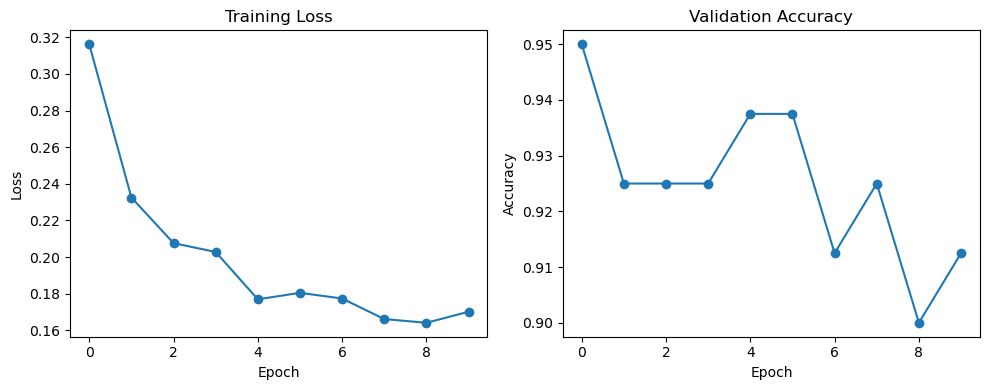

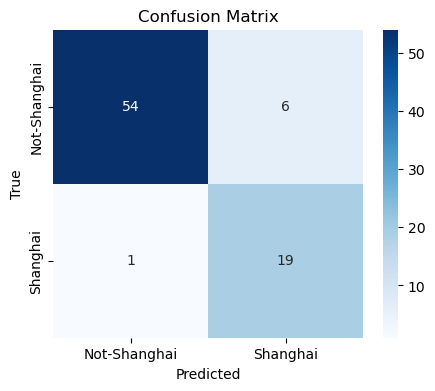

Classification report:
              precision    recall  f1-score   support

Not-Shanghai     0.9818    0.9000    0.9391        60
    Shanghai     0.7600    0.9500    0.8444        20

    accuracy                         0.9125        80
   macro avg     0.8709    0.9250    0.8918        80
weighted avg     0.9264    0.9125    0.9155        80



In [11]:
from sklearn.metrics import confusion_matrix, classification_report

# 1) Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["loss"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(history["val_acc"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

# 2) Confusion matrix on test set
binary_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = binary_model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

labels = ["Not-Shanghai", "Shanghai"]
cm = confusion_matrix(all_labels, all_preds, labels=[0,1])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=labels, digits=4))
